In [68]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense,Normalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import random as rd

In [69]:
ds_train=pd.read_csv("../train_hora.csv")
ds_train["date"]=pd.to_datetime(ds_train["date"],format="%Y-%m-%d %H:%M:%S")
ds_train=ds_train.set_index("date")
ds_test=pd.read_csv("../test_hora.csv")
ds_test["date"]=pd.to_datetime(ds_test["date"],format="%Y-%m-%d %H:%M:%S")
ds_test=ds_test.set_index("date")

In [70]:
t_media=pd.read_csv("../temperaturas/DMC_330020_Quinta_Normal_Santiago_media.csv",sep=";")
t_media["date"]=pd.to_datetime(t_media["date"],format="%Y-%m-%d %H:%M:%S")
t_media=t_media.set_index("date")
fin= datetime.strptime("2023-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
t_media_fin=t_media.loc[fin]
t_media=t_media.query("date.dt.year>2017 and date.dt.year<2023")
t_media.loc[fin]=t_media_fin
t_minima=pd.read_csv("../temperaturas/DMC_330020_Quinta_Normal_Santiago_minima.csv",sep=";")
t_minima["date"]=pd.to_datetime(t_minima["date"],format="%Y-%m-%d %H:%M:%S")
t_minima=t_minima.set_index("date")
t_minima_fin=t_minima.loc[fin]
t_minima=t_minima.query("date.dt.year>2017 and date.dt.year<2023")
t_minima.loc[fin]=t_minima_fin
t_maxima=pd.read_csv("../temperaturas/DMC_330020_Quinta_Normal_Santiago_maxima.csv",sep=";")
t_maxima["date"]=pd.to_datetime(t_maxima["date"],format="%Y-%m-%d %H:%M:%S")
t_maxima=t_maxima.set_index("date")
t_maxima_fin=t_maxima.loc[fin]
t_maxima=t_maxima.query("date.dt.year>2017 and date.dt.year<2023")
t_maxima.loc[fin]=t_maxima_fin

In [71]:
t_media_hora=t_media.resample("1h").ffill()
t_maxima_hora=t_maxima.resample("1h").ffill()
t_minima_hora=t_minima.resample("1h").ffill()
t_media_train=t_media_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_media_test=t_media_hora.query("date.dt.year==2022")
t_minima_train=t_minima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_minima_test=t_minima_hora.query("date.dt.year==2022")
t_maxima_train=t_maxima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_maxima_test=t_maxima_hora.query("date.dt.year==2022")

In [72]:
ds_train=ds_train.join(t_minima_train["t_minima"])
ds_train=ds_train.join(t_media_train["t_media"])
ds_train=ds_train.join(t_maxima_train["t_maxima"])
ds_train["w"]=ds_train.index.dayofweek
ds_train["m"]=ds_train.index.month
ds_train["h"]=ds_train.index.hour
print(pearsonr(ds_train["consumption"],ds_train["t_media"]))
print(pearsonr(ds_train["consumption"],ds_train["t_minima"]))
print(pearsonr(ds_train["consumption"],ds_train["t_maxima"]))
print(pearsonr(ds_train["consumption"],ds_train["w"]))
print(pearsonr(ds_train["consumption"],ds_train["m"]))
print(pearsonr(ds_train["consumption"],ds_train["h"]))

PearsonRResult(statistic=-0.48083788888868956, pvalue=0.0)
PearsonRResult(statistic=-0.4364928885507775, pvalue=0.0)
PearsonRResult(statistic=-0.44762732525762555, pvalue=0.0)
PearsonRResult(statistic=-0.16901818798725682, pvalue=5.429055703234984e-223)
PearsonRResult(statistic=0.1265849293928329, pvalue=3.465196248245333e-125)
PearsonRResult(statistic=0.5246818887301639, pvalue=0.0)


In [73]:
ds_test=ds_test.join(t_minima_test["t_minima"])
ds_test=ds_test.join(t_media_test["t_media"])
ds_test=ds_test.join(t_maxima_test["t_maxima"])
ds_test["w"]=ds_test.index.dayofweek
ds_test["m"]=ds_test.index.month
ds_test["h"]=ds_test.index.hour
print(pearsonr(ds_test["consumption"],ds_test["t_media"]))
print(pearsonr(ds_test["consumption"],ds_test["t_minima"]))
print(pearsonr(ds_test["consumption"],ds_test["t_maxima"]))
print(pearsonr(ds_test["consumption"],ds_test["w"]))
print(pearsonr(ds_test["consumption"],ds_test["m"]))
print(pearsonr(ds_test["consumption"],ds_test["h"]))

PearsonRResult(statistic=-0.5694986997612126, pvalue=0.0)
PearsonRResult(statistic=-0.5342029994894597, pvalue=0.0)
PearsonRResult(statistic=-0.5223074129267719, pvalue=0.0)
PearsonRResult(statistic=-0.1262871138294452, pvalue=1.784645742428329e-32)
PearsonRResult(statistic=0.03290210819630109, pvalue=0.002070958740669617)
PearsonRResult(statistic=0.47756823164543905, pvalue=0.0)


In [74]:
y_train=ds_train[["consumption","t_media","w","h"]].to_numpy()
y_test=ds_test[["consumption","t_media","w","h"]].to_numpy()
print(len(y_train)+len(y_test))

43824


In [83]:
yw_train=[]
ytw_train=[]
window=336
for i in range(0,len(y_train)):
    if i+window < len(y_train):
        row=[]
        for j in range(168):
            row.append(y_train[i+j])
        yw_train.append(row)
        row=[]
        for j in range(168):
            row.append(y_train[i+48+j][0])
        ytw_train.append(row)
    else:
        break
yw_train=np.asarray(yw_train)
ytw_train=np.asarray(ytw_train)
print(yw_train.shape,ytw_train.shape)

(34728, 168, 4) (34728, 168)


In [84]:
yw_test=[]
ytw_test=[]
window=336
for i in range(0,len(y_test)):
    if i+window < len(y_test):
        row=[]
        for j in range(168):
            row.append(y_test[i+j])
        yw_test.append(row)
        row=[]
        for j in range(168):
            row.append(y_test[i+48+j][0])
        ytw_test.append(row)
    else:
        break
yw_test=np.asarray(yw_test)
ytw_test=np.asarray(ytw_test)
print(yw_test.shape,ytw_test.shape)

(8424, 168, 4) (8424, 168)


In [85]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(168,4)))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dense(168, activation='linear'))
tag="rnn_htw"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    restore_best_weights=True
)
optimizer=Adam(learning_rate=1e-5)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw_train, ytw_train, validation_data=(yw_test,ytw_test),
                batch_size=256, epochs=64,shuffle=True,verbose=1,
                callbacks=[tensorboard_callback,earlystopping_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 18.4644 - mae: 18.9582 - mse: 590.5533 - val_loss: 11.4232 - val_mae: 11.9133 - val_mse: 225.3443
Epoch 2/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - loss: 9.4910 - mae: 9.9815 - mse: 148.8687 - val_loss: 9.3125 - val_mae: 9.8027 - val_mse: 140.6409
Epoch 3/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - loss: 8.5594 - mae: 9.0492 - mse: 120.3423 - val_loss: 7.6579 - val_mae: 8.1448 - val_mse: 104.7621
Epoch 4/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 6.9373 - mae: 7.4231 - mse: 88.2362 - val_loss: 5.7783 - val_mae: 6.2605 - val_mse: 67.9969
Epoch 5/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 5.2634 - mae: 5.7437 - mse: 58.2599 - val_loss: 5.3540 - val_mae: 5.8351 - val_mse: 59.0786
Epoch 6/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 5.0036 - mae: 5.4824 - mse: 54.4063 - val_loss: 4.8848 - val_mae: 5.3636 - val_mse: 51.7214
Epoch 7/64
136/136 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - loss: 4.4604 - ma

In [88]:
ultimo=yw_test[0].reshape(1,168,4)
ultimo.shape

(1, 168, 4)

31.84599220386905 1.2102318543243407 0.03800264242284486 0.04485785470099492


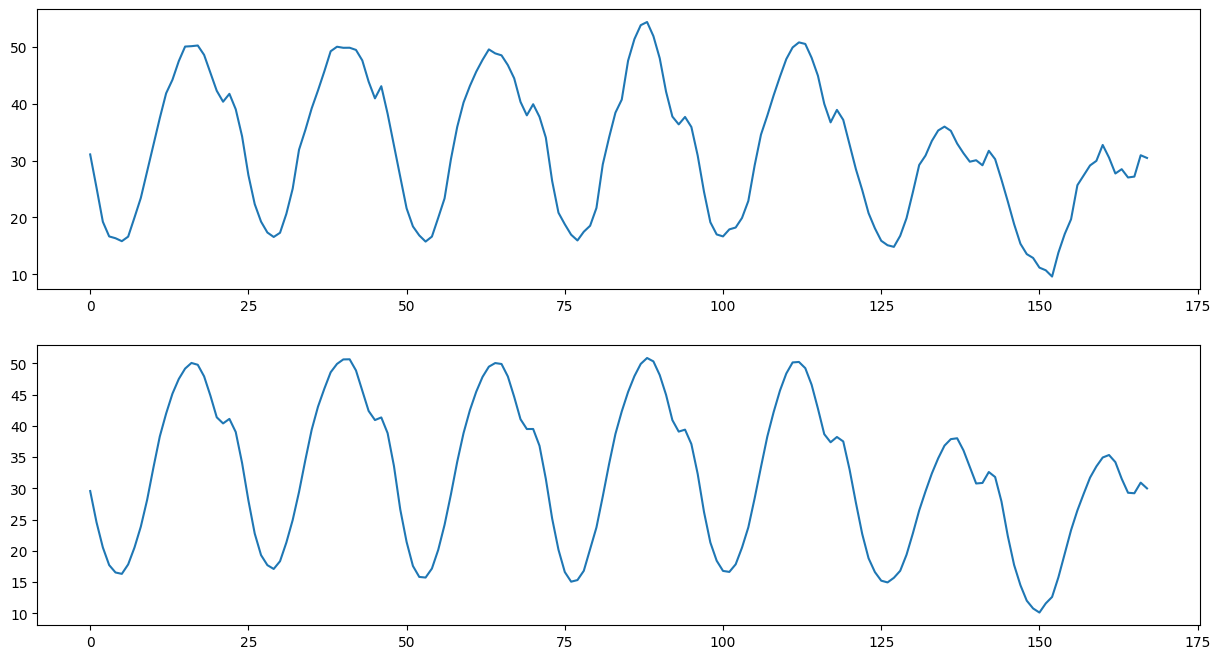

In [90]:
forecast=model.predict(ultimo,verbose=0)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
real=ytw_test[0].tolist()
pred=forecast[0].tolist()
axes[0].plot(real);
axes[1].plot(pred);
media=np.mean(real)
error=mean_absolute_error(real,pred)
error2=mean_absolute_percentage_error(real,pred)
print(media,error,error/media,error2)